In [5]:
import numpy
import pandas
import scipy.signal

from matplotlib import pyplot as plt

## Example problem

We use as an example a system which we model as having 3 distinct states:

- s1 (low values)
- s2 (medium values)
- s3 (high values)

And we want that when going from low to high, the values will go through medium state.
But when moving from high to low, the medium state shall not be included.

For this example we will use a toy synthetic dataset.

The approach shown should work just as well for other HMMs, be it multi-variate GMMs, Poission emissions, discrete

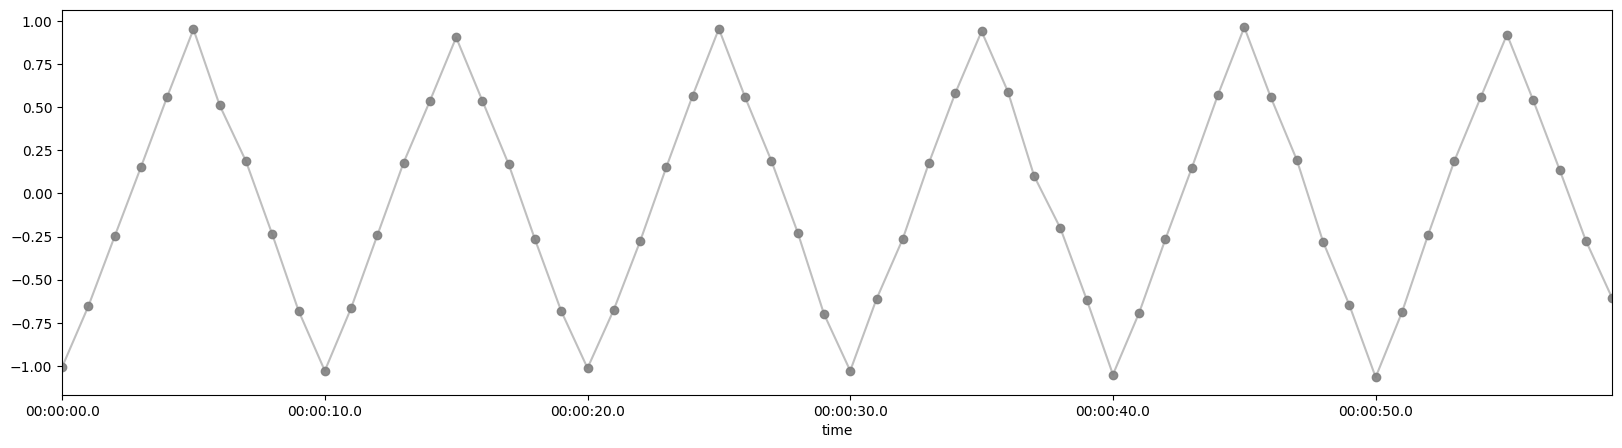

In [64]:

def sinewave(freq, duration, samplerate):
    sin = numpy.sin(2*numpy.pi*(freq/samplerate)*t)
    return sin, t

def triangle(freq, duration, samplerate, phase=0.5):

    t = numpy.arange(samplerate*duration)
    triangle = scipy.signal.sawtooth(2*numpy.pi*freq*(t/samplerate), phase)
    return triangle, t
    
def make_series(shape='triangle', period='10sec', freq='1sec', duration='1min'):
    period = pandas.Timedelta(period)
    duration = pandas.Timedelta(duration)
    freq = pandas.Timedelta(freq)
    
    if shape == 'sine':
        w = sinewave(1/period.total_seconds(), duration.total_seconds(), freq.total_seconds())
    elif shape == 'triangle':
        w = triangle(1/period.total_seconds(), duration.total_seconds(), freq.total_seconds())
    else:
        raise ValueError(f"Unknown shape '{shape}'")
    y, t = w
    y = y + (-.1 * numpy.random.random(size=len(y)) )
    #y = 0
    t = pandas.to_timedelta(t, unit='s')
    s = pandas.Series(y, index=t)
    s.index.name = 'time'
    return s

def plot_data(X, states=None, title=''):
    fig, ax = plt.subplots(1, figsize=(20, 5))
    fig.suptitle(title)

    # Plot data
    X.plot(ax=ax, marker='o', ls='none', color='grey', alpha=0.9)
    X.plot(ax=ax, ls='-', alpha=0.5, color='grey')

    # Plot states
    # FIXME: use one color per state
    if states is not None:
        ax2 = ax.twinx()
        n_states = len(numpy.unique(states))
        for s_no in range(n_states):
            sub = states[states == s_no]
            sub.plot(ax=ax2,ls='none', marker='o', ms=5, label=f's{s_no}')
        ax2.legend()
            
X = make_series(period='10sec')
plot_data(X)

## hmmlearn implementation

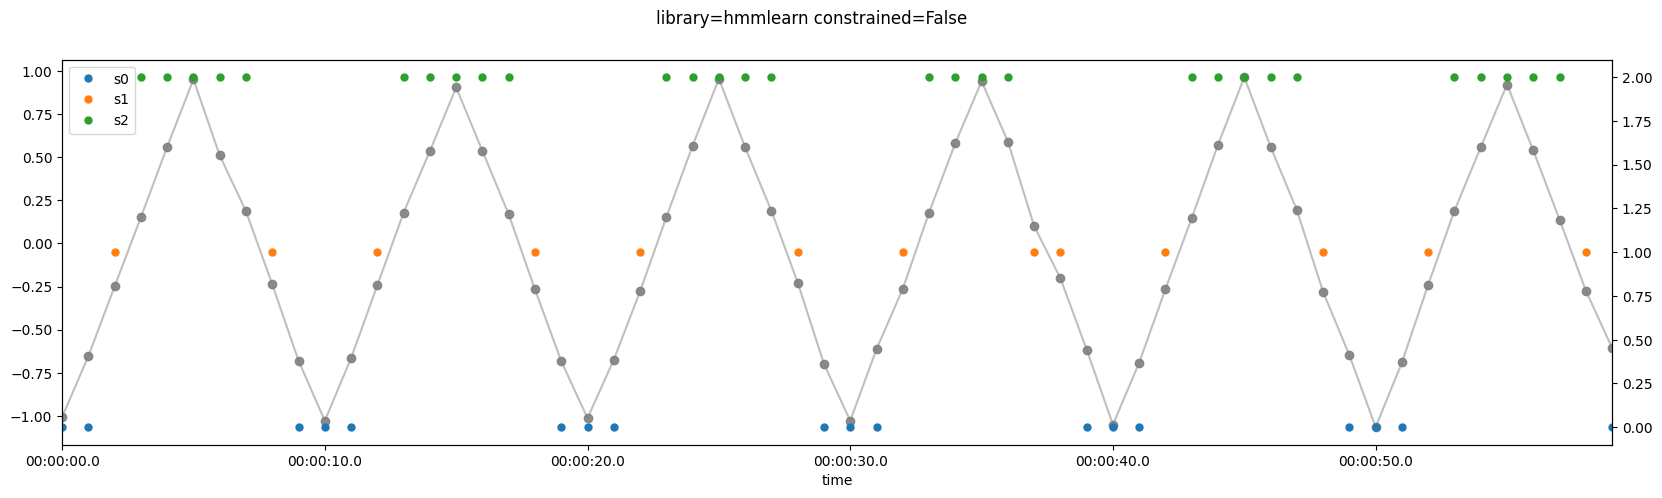

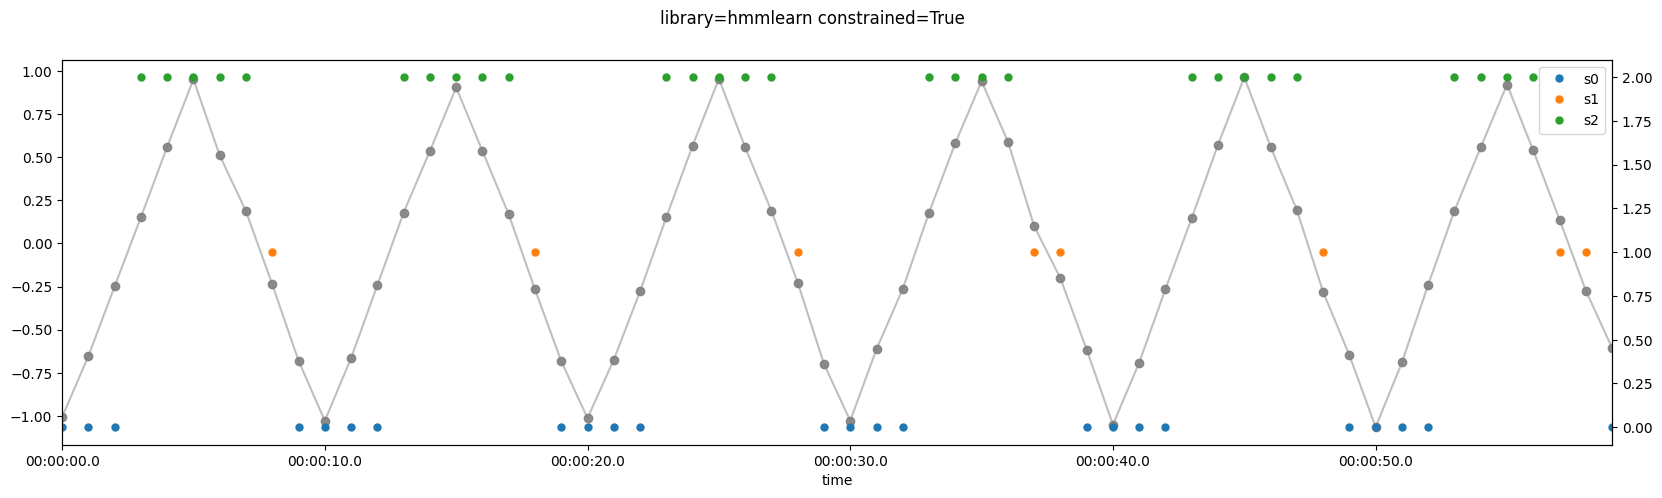

In [65]:
import hmmlearn.hmm

class ConstrainedGaussianHMM(hmmlearn.hmm.GaussianHMM):
    def _do_mstep(self, stats):
        
        # do the standard HMM learning step
        super()._do_mstep(stats)
        
        # find which states are where
        # we name them based on their typical value
        m = numpy.squeeze(self.means_)
        s = numpy.argsort(m)
        s1, s2, s3 = s
        
        # constrain the transition matrix
        # disallow s1->s2 and/or s2->s3 is not allowed
        self.transmat_[s1,s2] = 0.0
        self.transmat_[s2,s3] = 0.0


def format_sequence_hmmlearn(s):
    return s.values.reshape(-1, 1)

def test_hmmlearn_model(X, constrain):
    
    # Chose model
    if constrain:
        Model = ConstrainedGaussianHMM
    else:
        Model = hmmlearn.hmm.GaussianHMM

    model = Model(n_components=3, covariance_type='diag')
    model.fit(format_sequence_hmmlearn(X))

    # sort states based on their value
    mapping = numpy.argsort(numpy.squeeze(model.means_))
    inv_mapping = numpy.argsort(mapping)

    # Estimate states
    scores = model.score_samples(format_sequence_hmmlearn(X))[1]
    states = inv_mapping[numpy.argmax(scores, axis=1)]
    states = pandas.Series(states, index=X.index)
    
    # Visualize data and results
    plot_data(X, states=states, title=f'library=hmmlearn constrained={constrain}')

test_hmmlearn_model(X, constrain=False)
test_hmmlearn_model(X, constrain=True)
    
#print(states)

## Pomegranate implementation

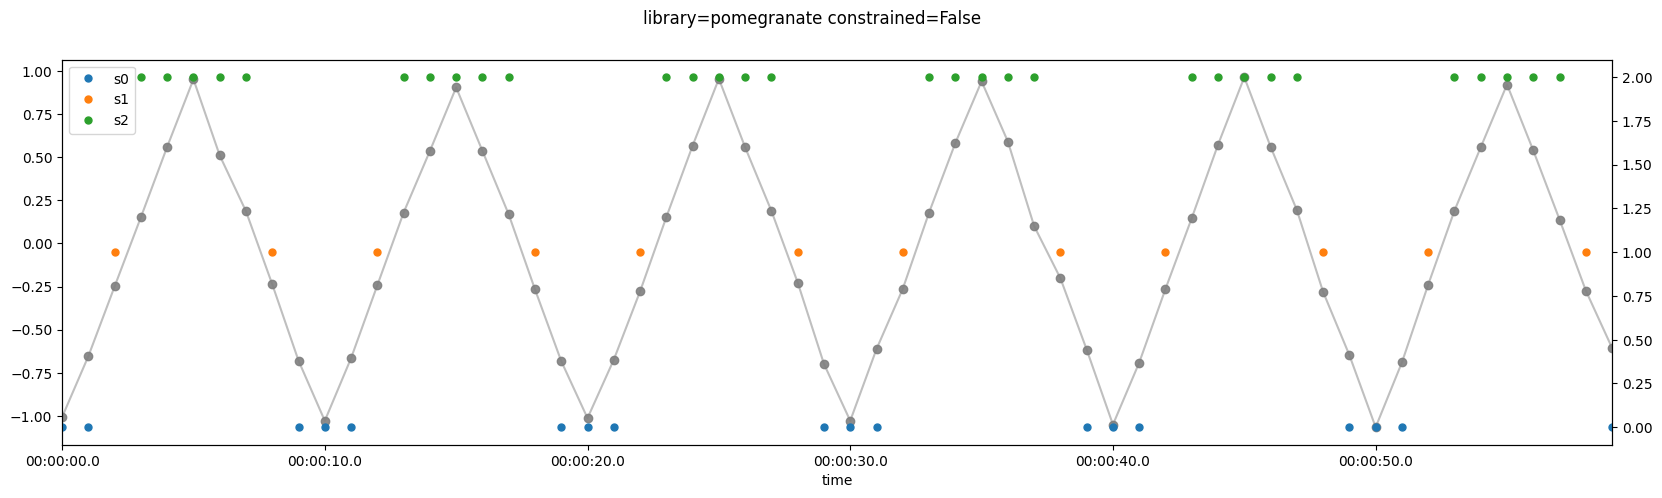

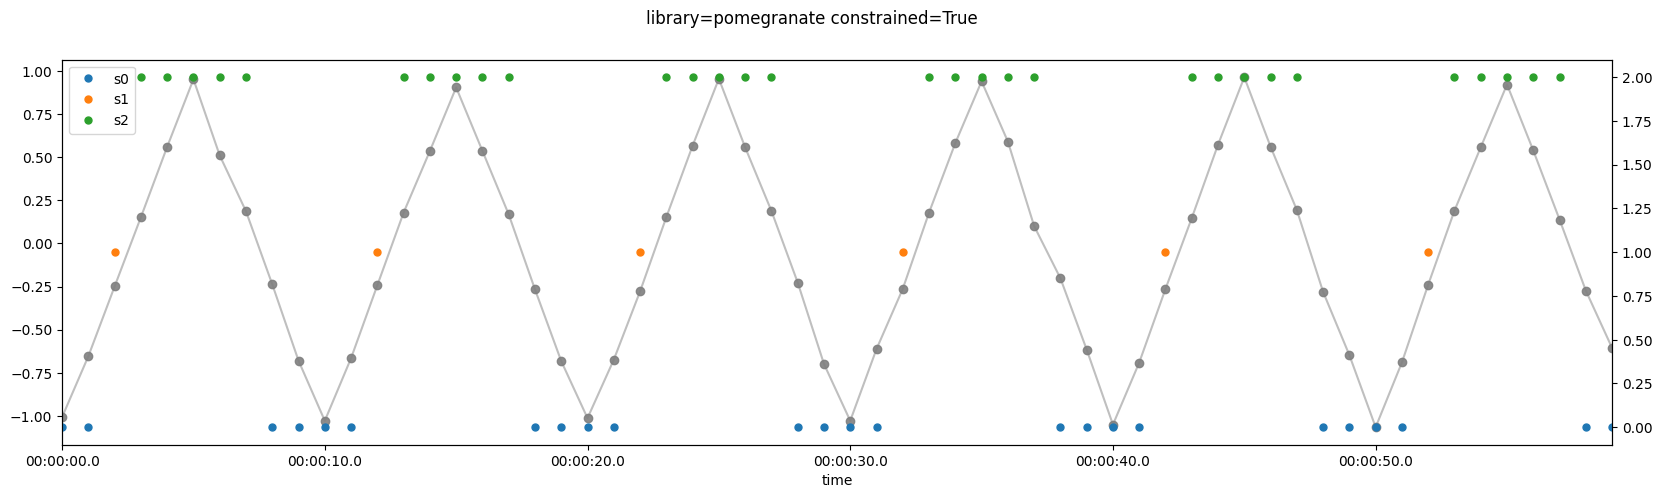

In [72]:
def get_parameters(model):
    parameters = dict(
        name = [],
        mean = [],
        std = [],
    )
    
    for s in model.states:
        if not s.name.startswith('s'):
            # skip start/end state
            continue

        mean, std = s.distribution.parameters
        parameters['mean'].append(mean)
        parameters['std'].append(std)
        parameters['name'].append(s.name)
            
    df = pandas.DataFrame(parameters).set_index('name')
    return df


import pomegranate


def initialize_distributions_kmeans(X, n_components,
                        distribution=pomegranate.NormalDistribution,
                        init="kmeans++",
                        max_kmeans_iterations=1,
                        n_init=1,
                        batches_per_epoch=None,
                        random_state=None,
                       ):
    """
    Implement 
    
    Copied from the function from_samples()
    """
    
    from pomegranate.hmm import _initialize_distributions
    from pomegranate.kmeans import Kmeans
    
    X_concat = numpy.concatenate(X)
    if X_concat.ndim == 1:
        X_concat = X_concat.reshape(-1, 1)

    clf = Kmeans(n_components, init=init, n_init=n_init)
    clf.fit(X_concat,
            max_iterations=max_kmeans_iterations,
            batches_per_epoch=batches_per_epoch,
            random_state=random_state)
    y = clf.predict(X_concat)

    X_ = [X_concat[y == i] for i in range(n_components)]
    distributions = _initialize_distributions(X_, distribution)

    return distributions



def build_pomegranate_hmm(constrain, X=None, distribution=pomegranate.NormalDistribution):
    from pomegranate import State, HiddenMarkovModel
    
    distributions = initialize_distributions_kmeans(X=X, n_components=3, distribution=distribution, n_init=10)

    def distribution_mean(d):
        return d.parameters[1] 
    
    # sort according to value
    distributions = sorted(distributions, key=distribution_mean)    
    d1, d2, d3 = distributions

    s1 = State(d1, name="s1")
    s2 = State(d2, name="s2")
    s3 = State(d3, name="s3")
    states = [s1, s2, s3]
    
    model = HiddenMarkovModel('example')
    model.add_states(states)

    if not constrain:
        # if contrained, then s1->s2 and/or s2->s3 is not allowed
        model.add_transition(s1, s2, 1.0)
        model.add_transition(s2, s3, 1.0)
        pass
        
    model.add_transition(s3, s1, 1.0)
    model.add_transition(s1, s3, 1.0)
    model.add_transition(s3, s2, 1.0)
    model.add_transition(s2, s1, 1.0)

    # self transitions
    for s in states:
        model.add_transition(s, s, 0.1)
    
    # start/end
    for s in states:
        model.add_transition(model.start, s, 1.0)
        #model.add_transition(model.end, s, 1.0)
    
    model.bake()
    
    return model
        
        
def test_pomegranate_model(X, constrain):
    import functools
    from pomegranate import HiddenMarkovModel
    
    # Chose model
    model = build_pomegranate_hmm(constrain=constrain, X=[X])

    # Estimate states
    model.fit([X], min_iterations=10)
    
    #model.plot() # XXX: when enabled, messes up the other plots!?!?

    # sort states based on their value
    means = get_parameters(model)['mean']
    mapping = numpy.argsort(means)
    inv_mapping = numpy.argsort(mapping)

    scores = model.predict_proba(X)
    states = inv_mapping[numpy.argmax(scores, axis=1)].values
    states = pandas.Series(states, index=X.index)
    
    # Visualize data and results
    plot_data(X, states=states, title=f'library=pomegranate constrained={constrain}')

test_pomegranate_model(X, constrain=False)
test_pomegranate_model(X, constrain=True)